In [1]:
import mne
import pickle

In [2]:
with open('bcci_data_preprocessed.pkl','rb') as f:
    dataset=pickle.load(f)

print("Preprocessed data has been loaded from 'bcci_data_preprocessed.pkl'")

C:\Users\dyuti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Preprocessed data has been loaded from 'bcci_data_preprocessed.pkl'


In [3]:
input_window_samples = 1000

In [4]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    _ = model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 23, 1000]             [1, 4, 32]                --                        --
├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 40, 976, 1]           37,840                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 976, 1]           [1, 40, 976, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 976, 1]           [1, 40, 976, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 976, 1]           [1, 40, 61, 1]            --                        [75, 1]
├─Express

C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [5]:
model.to_dense_prediction_model()

In [6]:
n_preds_per_input = model.get_output_shape()[2]

In [7]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [8]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test'] 

In [10]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
from braindecode.training import CroppedLoss

lr = 0.0625 * 0.01
weight_decay = 0
batch_size=64
n_epochs=50

In [11]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr       dur
-------  ----------------  ------------  ----------------  ------------  ------  --------
      1            0.3407        1.6564            0.3299        1.3968  0.0006  155.5753
      2            0.3954        1.5031            0.3819        1.3540  0.0006  151.3034
      3            0.4680        1.4101            0.4290        1.3582  0.0006  149.5212
      4            0.5073        1.3337            0.4417        1.2439  0.0006  146.4554
      5            0.5112        1.2645            0.4691        1.2177  0.0006  152.1828
      6            0.5324        1.2287            0.4784        1.2228  0.0006  61.7230
      7            0.5066        1.1786            0.4684        1.2521  0.0006  70.1572
      8            0.4630        1.1523            0.4298        1.2387  0.0006  85.6151
      9            0.5949        1.1215            0.5247        1.1780  0.0006  87.7758
     10       

In [12]:
import joblib

In [13]:
file1='cropped_shallow_bcci.sav'

In [14]:
joblib.dump(clf,file1)

['cropped_shallow_bcci.sav']

In [12]:
clf=joblib.load(file1)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


In [15]:
#labels=[valid_set[i][1] for i in range (len(valid_set))]
#labels

[1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 3,
 3,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 0,
 3,
 3,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 3,
 3,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 0,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 1,
 1,
 3,
 3,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 3,
 3,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 3,
 3,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 1,
 1,
 3,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,


In [19]:
#accuracy=clf.score(valid_set,y=labels)
#print(f'Shallow Model Accuracy: {accuracy:.4f}')

In [18]:
clf.history[-1,'valid_accuracy']

0.6346450617283951

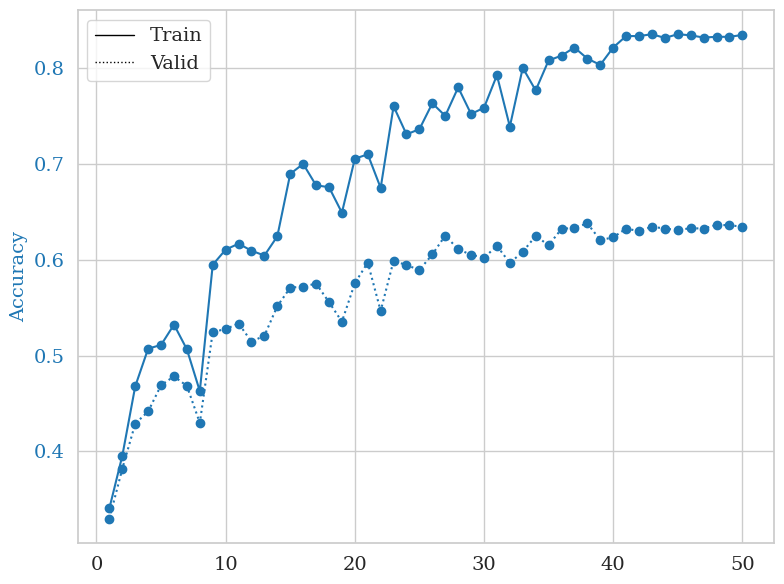

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy',
                   'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

fig, ax1 = plt.subplots(figsize=(8,6))
df.loc[:, ['train_accuracy', 'valid_accuracy']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False,
    fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Accuracy", color='tab:blue', fontsize=14)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# df.loc[:, ['train_misclass', 'valid_misclass']].plot(
#     ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
# ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
# ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
# ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
# ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

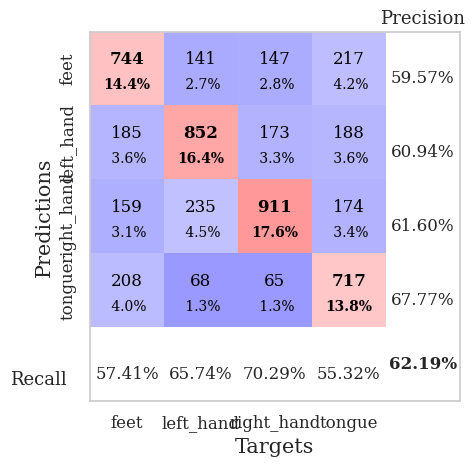

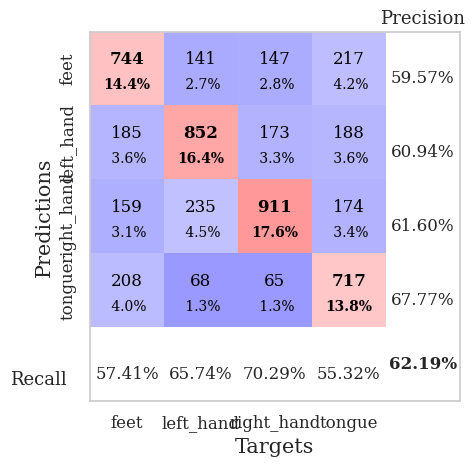

In [24]:
from sklearn.metrics import confusion_matrix

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = valid_set.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)

In [25]:
for i in range(n_classes):
    for j in range(i+1,n_classes):
        misclassified_i_as_j=confusion_mat[i,j]  # Class i misclassified as class j
        misclassified_j_as_i=confusion_mat[j,i]  # Class j misclassified as class i
        print(f"Class {i} misclassified as Class {j}: {misclassified_i_as_j} times")
        print(f"Class {j} misclassified as Class {i}: {misclassified_j_as_i} times")

Class 0 misclassified as Class 1: 185 times
Class 1 misclassified as Class 0: 141 times
Class 0 misclassified as Class 2: 159 times
Class 2 misclassified as Class 0: 147 times
Class 0 misclassified as Class 3: 208 times
Class 3 misclassified as Class 0: 217 times
Class 1 misclassified as Class 2: 235 times
Class 2 misclassified as Class 1: 173 times
Class 1 misclassified as Class 3: 68 times
Class 3 misclassified as Class 1: 188 times
Class 2 misclassified as Class 3: 65 times
Class 3 misclassified as Class 2: 174 times


In [22]:
valid_set.datasets[0].window_kwargs[0][1]['mapping']

{'feet': 0, 'left_hand': 1, 'right_hand': 2, 'tongue': 3}

NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


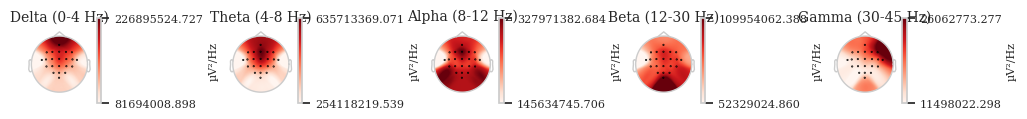

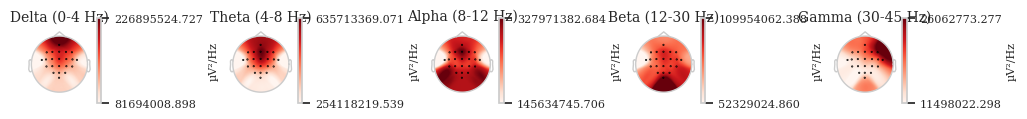

In [23]:
dataset.datasets[0].raw.plot_psd_topomap() #tongue